# Modified toy model for UHECR track generation

In [1]:
%matplotlib inline
from generate_sample_frames_modified import *
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from matplotlib import pyplot as plt
import pickle
import time
import tensorflow as tf

C:\Users\Figge\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


genarated 540 frames of background
genarated 540 background labels
displaying a random sample of 40 frames: 


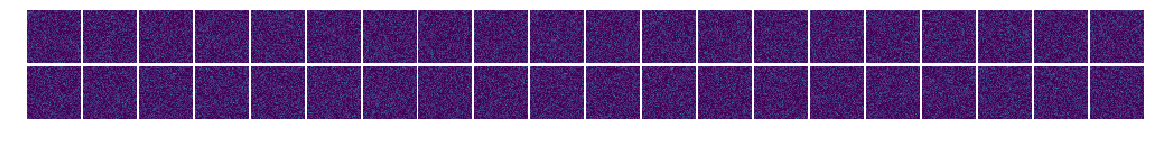

generated 540 frames of tracks
genarated 540 track labels
displaying a random sample of 40 frames: 


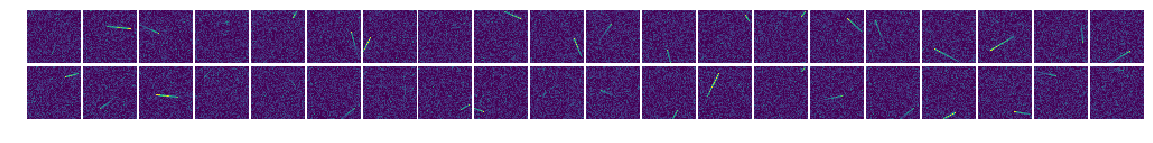

saved generated frames to file in samples/


In [2]:
# set up the TrackModel
track_model = TrackModel()
track_model.mu_c = 10 # mean track brightness
n_frame = 540

# generate sample background and tracks
with SampleGenerator(track_model) as generator:
    generator.background(n_frame)
    generator.tracks(n_frame)
    generator.save()

In [3]:
# Load background data
outfilename = 'samples/sample_generator_bg.dat'
with open(outfilename, 'rb') as f:
    data_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track.dat'
with open(outfilename, 'rb') as f:
    data_track = pickle.load(f)

In [4]:
# Load track data
outfilename = 'samples/sample_generator_bg_labels.dat'
with open(outfilename, 'rb') as f:
    labels_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track_labels.dat'
with open(outfilename, 'rb') as f:
    labels_track = pickle.load(f)

In [5]:
# Set up a norm for the plots
norm = generator.norm

this image has label:  [0. 1.]


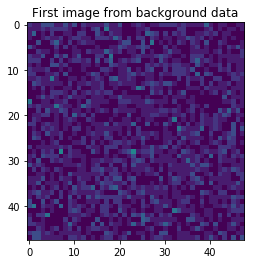

In [6]:
#Look at the first background image
plt.imshow(data_bg[0], norm=norm)
plt.title("First image from background data")

# and its corresponding label
print ("this image has label: ", labels_bg[0])

this image has label:  [1. 0.]


(-0.5, 47.5, 47.5, -0.5)

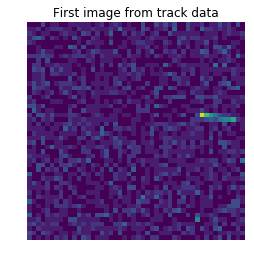

In [7]:
#Look at the first track image
plt.imshow(data_track[0], norm=norm)
plt.title("First image from track data")

# and its corresponding label
print ("this image has label: ", labels_track[0])
plt.axis('off')
#plt.savefig('fig.png', format='png', dpi=100) # save figure

In [8]:
# Reshape and shuffle data
data = np.concatenate([data_bg, data_track])
data = np.reshape(data, (2*n_frame, 48, 48, 1))

labels = np.concatenate([labels_bg, labels_track])

data, labels = shuffle(data, labels)

validation_ratio = 1/5
index = int(1 - validation_ratio*np.shape(data)[0]/2)-1
# should be index = int(1 - 1/((1/(validation_ratio+1)))*np.shape(data)[0]/2)-1     ?

data_test = data[index:]
labels_test = labels[index:]

data = data[0:index]
labels = labels[0:index]

In [8]:
# Callback class for keeping track of best accuracy and loss
class MonitorCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.best_acc = 0
        self.best_loss = 10
        self.best_params = None
        self.best_val_acc_epoch = None
        self.best_loss_epoch = None
    
    def on_epoch_end(self, training_state, snapshot=False):
        if training_state.val_acc > self.best_acc:
            self.best_acc = training_state.val_acc
            self.best_val_acc_epoch = training_state.epoch
            
        if training_state.global_loss < self.best_loss:
            self.best_loss = training_state.global_loss
            self.best_loss_epoch = training_state.epoch
        
    def getBestValAccEpoch(self):
        return self.best_val_acc_epoch
        
    def getBestLossEpoch(self):
        return self.best_loss_epoch
        
    def getBestValAcc(self):
        return self.best_acc 
        
    def getBestLoss(self):
        return self.best_loss
    
monitorCallback = MonitorCallback()

In [9]:
# Callback class for saving accuracy and loss to a file
class DataSaveCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.g = open("val_acc.txt","w+")
        self.h = open("loss.txt","w+")
    def on_epoch_end(self, training_state, snapshot=False):
        g = open("val_acc.txt", "a+")
        g.write(str(training_state.step))
        g.write(" ")
        g.write(str(training_state.val_acc))
        g.write("\n")
    def on_batch_end(self, training_state, snapshot=False):
        h = open("loss.txt", "a+")
        h.write(str(training_state.step))
        h.write(" ")
        h.write(str(training_state.global_loss))
        h.write("\n")

In [10]:
start_time = time.time()

# Define the network architecture:

# Input is a 48x48 image with 1 "color" channel
network = input_data(shape=[None, 48, 48, 1])

# Step 1: Convolution
network = conv_2d(network, 16, 3, activation='relu')

# Step 2: Max pooling
network = max_pool_2d(network, 2)

# Step 3: Convolution again
network = conv_2d(network, 64, 3, activation='relu')

# Step 4: Max pooling again
network = max_pool_2d(network, 2)

# Step 5: Convolution yet again
network = conv_2d(network, 16, 3, activation='relu')

# Step 6: Max pooling again
network = max_pool_2d(network, 2)

# Step 7: Fully-connected 128 node neural network
network = fully_connected(network, 128, activation='relu')

# Step 8: Dropout - throw away some data randomly during training to prevent overfitting
network = dropout(network, 0.5)

# Step 9: Fully connected neural network with two outputs
network = fully_connected(network, 2, activation='softmax')

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=0)

# Train it
model.fit(data, labels, n_epoch=50, shuffle=True, validation_set=(data_test, labels_test),
          show_metric=True, batch_size=64,
          #snapshot_epoch=True,
          run_id='track-classifier',
          callbacks = [monitorCallback, DataSaveCallback()])

# Save model when training is complete to a file
model.save("track-classifier.tfl")

end_time = time.time()

elapsed_time = end_time - start_time

print("Network trained and saved as track-classifier.tfl!")
print("The training took: ", elapsed_time)

Training Step: 159  | total loss: 0.26298 | time: 0.798s
| Adam | epoch: 010 | loss: 0.26298 - acc: 0.8868 -- iter: 960/972
Training Step: 160  | total loss: 0.25388 | time: 1.876s
| Adam | epoch: 010 | loss: 0.25388 - acc: 0.8935 | val_loss: 0.16188 - val_acc: 0.9444 -- iter: 972/972
--
INFO:tensorflow:C:\Users\Figge\Desktop\kex_2018-master\track-classifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as track-classifier.tfl!
The training took:  25.54788088798523


In [11]:
print('Best validation accuracy:', monitorCallback.getBestValAcc())
print('Achieved by the end of epoch', monitorCallback.getBestValAccEpoch())
print('')
print('Best loss:', monitorCallback.getBestLoss())
print('Achieved by the end of epoch', monitorCallback.getBestLossEpoch())

Best validation accuracy: 0.972222215599484
Achieved by the end of epoch 8

Best loss: 0.2538794279098511
Achieved by the end of epoch 10
